# Extrapolating line game model to new teaching stimuli

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

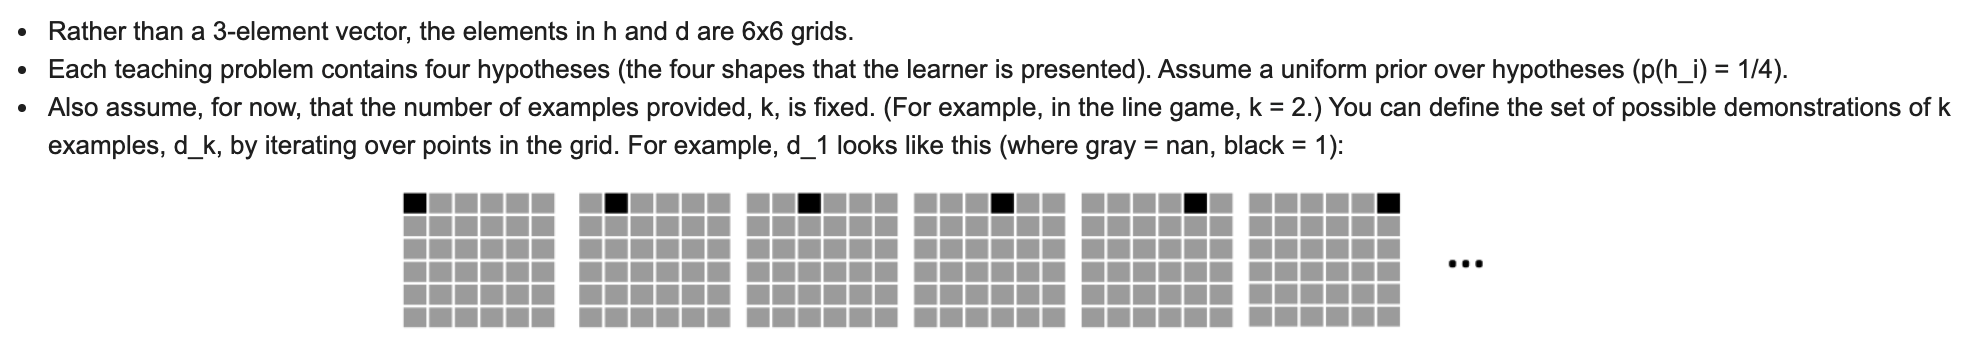

In [118]:
from make_df import make_df_from_spreadsheet

filename = 'teaching_stimuli - all_examples.csv'
all_problems = make_df_from_spreadsheet(filename)

In [120]:
def find_problem(index, all_problems):
    '''Return flat and non flat representations of a specific problem'''
    h = np.array([i for i in all_stimuli.loc[index,:].to_numpy(dtype=object)])
    h_flat = all_stimuli.loc[index,:].to_numpy(dtype=object) # Instead of 3d matrix, create an array of arrays
    print(h.shape)
    print(h_flat.shape)
    return h, h_flat

## View problem

In [4]:
def plot_problem(problem):
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = 'ABCD'

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080')
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

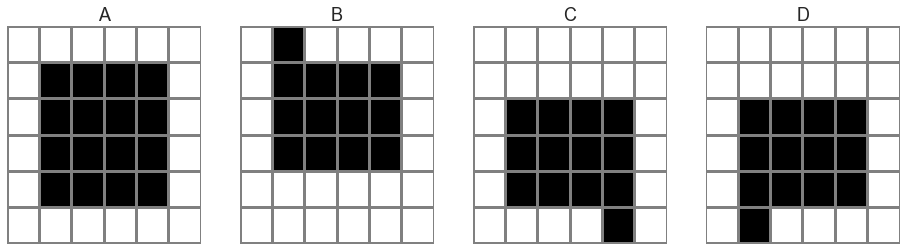

In [5]:
plot_problem(h)

## Start with $k=1$

In [6]:
# Get possible positive examples
# Don't need a mask here b/c we are already choosing from the positive examples
def get_pos_idx(concept):
    pos_coords = np.nonzero(concept)
    pos_idx = np.ravel_multi_index(pos_coords, (6,6))

    return list(pos_idx)

In [52]:
# Extract indices (flattened) of positive examples

d_possible = {}
columns = ['h_1', 'h_2', 'h_3', 'h_4']
rows = ['d_%i' % (i+1) for i in range(h_flat[0].size)]

for ex in range(len(h_flat)):
    d_possible[ex] = get_pos_idx(h_flat[ex])

In [49]:
d_possible

{0: [7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28],
 1: [1, 7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22],
 2: [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 34],
 3: [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 31]}

In [9]:
df_0 = pd.DataFrame(index=rows, columns=columns)

for k, v in d_possible.items(): 
    for i in v:
        df_0.iloc[i, k] = 1

# Drop rows without possible hypotheses, fill remaining NaNs with 0 
# df_0 = df_0.dropna(how='all').fillna(0)

# Columns should sum up to one (prior for each hypothesis is that you have an equal chance of teaching any of the data)
df_0 = df_0.div(df_0.sum(axis=0), axis=1)
df_0 = df_0.fillna(0)

In [10]:
# View
df_0

,h_1,h_2,h_3,h_4
d_1,0.0000,0.000000,0.000000,0.000000
d_2,0.0000,0.076923,0.000000,0.000000
d_3,0.0000,0.000000,0.000000,0.000000
d_4,0.0000,0.000000,0.000000,0.000000
d_5,0.0000,0.000000,0.000000,0.000000
d_6,0.0000,0.000000,0.000000,0.000000
d_7,0.0000,0.000000,0.000000,0.000000
d_8,0.0625,0.076923,0.000000,0.000000
d_9,0.0625,0.076923,0.000000,0.000000
d_10,0.0625,0.076923,0.000000,0.000000


In [11]:
def plot_prob_heatmap(df):
    plt.figure(figsize=(4.8,7))
    sns.heatmap(df, annot=True, linewidths=0.25)
    plt.title('$P_{teacher} (d|h)$')
    plt.show()

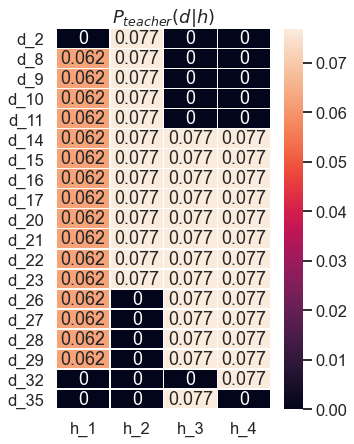

In [12]:
# Plot heatmap w/o 0 rows
plot_prob_heatmap(df_0.loc[(df_0!=0).any(axis=1)])

In [13]:
def find_teacher_probabilities(n, df_0):
    '''
    given number of iterations n and P(d|h) matrix for iteration 0, find P(d|h) matrix after iteration n 
    '''
    n_iter = n
    df = df_0

    for n in range(n_iter): 
        df = df.div(df.sum(axis=1), axis=0)  # P(h|d)
        df = df.div(df.sum(axis=0), axis=1)  # P(d|h)
    
    return df

In [14]:
df_500 = find_teacher_probabilities(500, df_0)

In [15]:
# Plot indices to make viz slightly easier
def plot_problem_with_indices(problem):
    
    indices = np.arange(1, h_flat[0].size + 1).reshape(6,6)
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = ['h_1', 'h_2', 'h_3', 'h_4']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080', annot=indices)
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

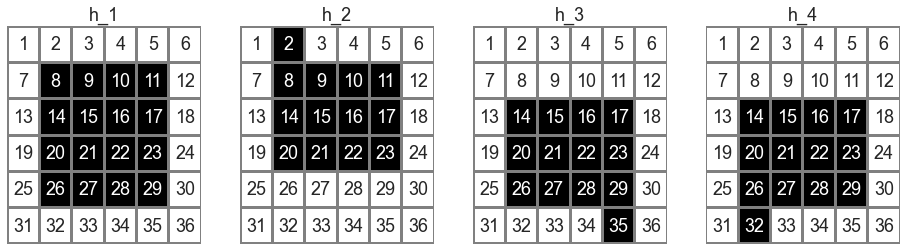

In [16]:
plot_problem_with_indices(h)

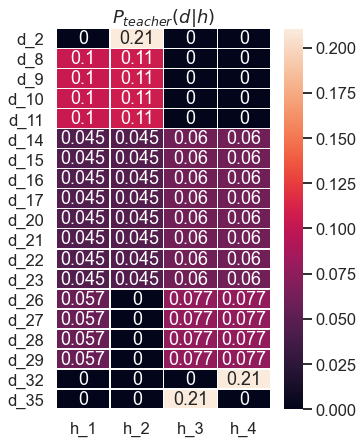

In [17]:
plot_prob_heatmap(df_500.dropna())

In [22]:
def plot_problem_with_probs(df):
    '''Plot probabilities heatmap given probabilities df'''
    problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle('$P_{teacher}(d|h)$', y=1.1)
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 
    #return problem

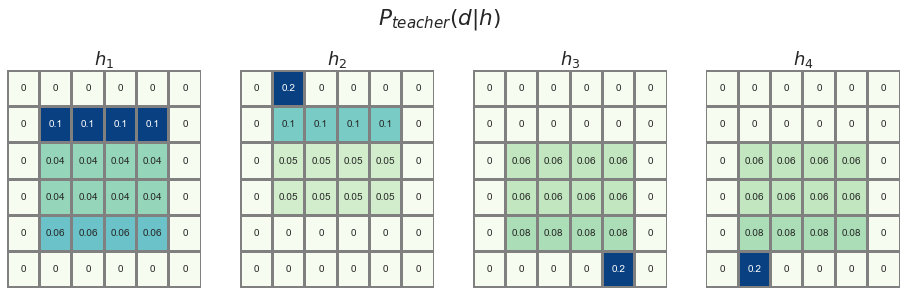

In [23]:
# probabilities heatmap for 500 iterations
plot_problem_with_probs(df_500)

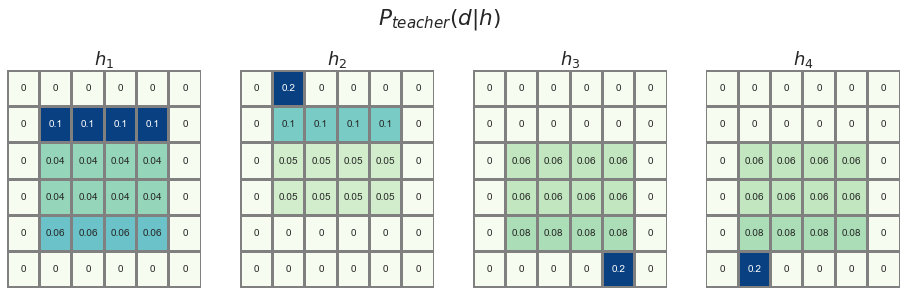

In [24]:
# 5000 iterations
df_5000 = find_teacher_probabilities(5000, df_0)
plot_problem_with_probs(df_5000)

## Cases of $k > 1$ 

Make a df with columns: square 1 index, square 2 index, square 3 index (all chosen from concept, so also no filter needed here)
(indices 1-36)

iterate over the four concepts and if a set of indices isn't already in the concept, add it in
or maybe just find all the sets? (in the union of all 4?) and delete the nan rows later 


bayes rule in a probablity matrix? is there any online documentation on stuff like this 

columns with all combinations, if all of them match the concept, then give it a 1 


In [40]:
indices = []
for i in range(36):
    for j in range(36):
        for k in range(36):
            indices.append((i,j,k))
            
indices = pd.MultiIndex.from_tuples(indices, names=('i_1', 'i_2', 'i_3'))
df_3ex = pd.DataFrame(columns=['h_1', 'h_2', 'h_3', 'h_4'], index=indices)

In [41]:
df

h_1  h_2  h_3  h_4
i_1 i_2 i_3                    
0   0   0    NaN  NaN  NaN  NaN
        1    NaN  NaN  NaN  NaN
        2    NaN  NaN  NaN  NaN
        3    NaN  NaN  NaN  NaN
        4    NaN  NaN  NaN  NaN
...          ...  ...  ...  ...
35  35  31   NaN  NaN  NaN  NaN
        32   NaN  NaN  NaN  NaN
        33   NaN  NaN  NaN  NaN
        34   NaN  NaN  NaN  NaN
        35   NaN  NaN  NaN  NaN

[46656 rows x 4 columns]

In [92]:
indices = []
for i in range(36):
    for j in range(36):
        indices.append((i,j))
            
indices = pd.MultiIndex.from_tuples(indices, names=('i_1', 'i_2'))
df_2ex = pd.DataFrame(columns=['h_1', 'h_2', 'h_3', 'h_4'], index=indices)

In [93]:
df_2ex

h_1  h_2  h_3  h_4
i_1 i_2                    
0   0    NaN  NaN  NaN  NaN
    1    NaN  NaN  NaN  NaN
    2    NaN  NaN  NaN  NaN
    3    NaN  NaN  NaN  NaN
    4    NaN  NaN  NaN  NaN
...      ...  ...  ...  ...
35  31   NaN  NaN  NaN  NaN
    32   NaN  NaN  NaN  NaN
    33   NaN  NaN  NaN  NaN
    34   NaN  NaN  NaN  NaN
    35   NaN  NaN  NaN  NaN

[1296 rows x 4 columns]

In [94]:
new_d_possible = {}
for ex in range(len(columns)):
    new_d_possible[columns[ex]] = d_possible[ex]
new_d_possible

{'h_1': [7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28],
 'h_2': [1, 7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22],
 'h_3': [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 34],
 'h_4': [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 31]}

In [95]:
for column in df_2ex.columns:
#for k in range(df_2ex.shape[1]):
    for i, j in df_2ex.index:
        #if all(x in new_d_possible[column] for x in [i, j]):
        if i in new_d_possible[column] and j in new_d_possible[column]:
            df_2ex.loc[(i,j), column] = 1
            


In [96]:
df_2ex_short = df_2ex.dropna(how='all')

In [98]:
# Make columns sum up to 1
def normalize_probs_and_fill_nans(df): 
    df = df.div(df.sum(axis=0), axis=1)
    df = df.fillna(0)
    return df

In [76]:
df_2ex = 

h_1  h_2  h_3  h_4
i_1 i_2                    
0   0    0.0  0.0  0.0  0.0
    1    0.0  0.0  0.0  0.0
    2    0.0  0.0  0.0  0.0
    3    0.0  0.0  0.0  0.0
    4    0.0  0.0  0.0  0.0
...      ...  ...  ...  ...
35  31   0.0  0.0  0.0  0.0
    32   0.0  0.0  0.0  0.0
    33   0.0  0.0  0.0  0.0
    34   0.0  0.0  0.0  0.0
    35   0.0  0.0  0.0  0.0

[1296 rows x 4 columns]

In [99]:
df_2ex_short_1 = normalize_probs_and_fill_nans(df_2ex_short)

In [100]:
df_2ex_short_1

h_1       h_2       h_3  h_4
i_1 i_2                              
1   1    0.0  0.005917  0.000000  0.0
    7    0.0  0.005917  0.000000  0.0
    8    0.0  0.005917  0.000000  0.0
    9    0.0  0.005917  0.000000  0.0
    10   0.0  0.005917  0.000000  0.0
...      ...       ...       ...  ...
34  25   0.0  0.000000  0.005917  0.0
    26   0.0  0.000000  0.005917  0.0
    27   0.0  0.000000  0.005917  0.0
    28   0.0  0.000000  0.005917  0.0
    34   0.0  0.000000  0.005917  0.0

[331 rows x 4 columns]

In [102]:
df_2ex_short_500 = find_teacher_probabilities(500, df_2ex_short_1)

In [103]:
df_2ex_short_500

h_1       h_2       h_3  h_4
i_1 i_2                              
1   1    0.0  0.012085  0.000000  0.0
    7    0.0  0.012085  0.000000  0.0
    8    0.0  0.012085  0.000000  0.0
    9    0.0  0.012085  0.000000  0.0
    10   0.0  0.012085  0.000000  0.0
...      ...       ...       ...  ...
34  25   0.0  0.000000  0.012085  0.0
    26   0.0  0.000000  0.012085  0.0
    27   0.0  0.000000  0.012085  0.0
    28   0.0  0.000000  0.012085  0.0
    34   0.0  0.000000  0.012085  0.0

[331 rows x 4 columns]

In [106]:
df_2ex_short_500.head(50)

h_1       h_2  h_3  h_4
i_1 i_2                              
1   1    0.000000  0.012085  0.0  0.0
    7    0.000000  0.012085  0.0  0.0
    8    0.000000  0.012085  0.0  0.0
    9    0.000000  0.012085  0.0  0.0
    10   0.000000  0.012085  0.0  0.0
    13   0.000000  0.012085  0.0  0.0
    14   0.000000  0.012085  0.0  0.0
    15   0.000000  0.012085  0.0  0.0
    16   0.000000  0.012085  0.0  0.0
    19   0.000000  0.012085  0.0  0.0
    20   0.000000  0.012085  0.0  0.0
    21   0.000000  0.012085  0.0  0.0
    22   0.000000  0.012085  0.0  0.0
7   1    0.000000  0.012085  0.0  0.0
    7    0.004941  0.007144  0.0  0.0
    8    0.004941  0.007144  0.0  0.0
    9    0.004941  0.007144  0.0  0.0
    10   0.004941  0.007144  0.0  0.0
    13   0.004941  0.007144  0.0  0.0
    14   0.004941  0.007144  0.0  0.0
    15   0.004941  0.007144  0.0  0.0
    16   0.004941  0.007144  0.0  0.0
    19   0.004941  0.007144  0.0  0.0
    20   0.004941  0.007144  0.0  0.0
    21   0.004941  0.007144  0.0  0.0
    22   0.004941  0.007144  0.0  0.0
    25   0.012085  0.000000  0.0  0.0
    26   0.012085  0.000000  0.0  0.0
    27   0.012085  0.000000  0.0  0.0
    28   0.012085  0.000000  0.0  0.0
8   1    0.000000  0.012085  0.0  0.0
    7    0.004941  0.007144  0.0  0.0
    8    0.004941  0.007144  0.0  0.0
    9    0.004941  0.007144  0.0  0.0
    10   0.004941  0.007144  0.0  0.0
    13   0.004941  0.007144  0.0  0.0
    14   0.004941  0.007144  0.0  0.0
    15   0.004941  0.007144  0.0  0.0
    16   0.004941  0.007144  0.0  0.0
    19   0.004941  0.007144  0.0  0.0
    20   0.004941  0.007144  0.0  0.0
    21   0.004941  0.007144  0.0  0.0
    22   0.004941  0.007144  0.0  0.0
    25   0.012085  0.000000  0.0  0.0
    26   0.012085  0.000000  0.0  0.0
    27   0.012085  0.000000  0.0  0.0
    28   0.012085  0.000000  0.0  0.0
9   1    0.000000  0.012085  0.0  0.0
    7    0.004941  0.007144  0.0  0.0
    8    0.004941  0.007144  0.0  0.0

In [109]:
# Sanity check 
df_2ex_short_500.sum(axis=0)

h_1    1.0
h_2    1.0
h_3    1.0
h_4    1.0
dtype: float64

In [116]:
# Sort by what examples would be the best for h1
df_2ex_short_500.sort_values(by=['h_1'], ascending=False).head(50)
# Oops, accidentally did it so that it double counts all the indices.... oops

h_1       h_2  h_3  h_4
i_1 i_2                              
26  10   0.012085  0.000000  0.0  0.0
28  10   0.012085  0.000000  0.0  0.0
25  8    0.012085  0.000000  0.0  0.0
    9    0.012085  0.000000  0.0  0.0
7   25   0.012085  0.000000  0.0  0.0
    26   0.012085  0.000000  0.0  0.0
    27   0.012085  0.000000  0.0  0.0
    28   0.012085  0.000000  0.0  0.0
27  9    0.012085  0.000000  0.0  0.0
25  10   0.012085  0.000000  0.0  0.0
26  9    0.012085  0.000000  0.0  0.0
    8    0.012085  0.000000  0.0  0.0
27  8    0.012085  0.000000  0.0  0.0
8   28   0.012085  0.000000  0.0  0.0
28  9    0.012085  0.000000  0.0  0.0
    8    0.012085  0.000000  0.0  0.0
26  7    0.012085  0.000000  0.0  0.0
8   27   0.012085  0.000000  0.0  0.0
    26   0.012085  0.000000  0.0  0.0
25  7    0.012085  0.000000  0.0  0.0
8   25   0.012085  0.000000  0.0  0.0
28  7    0.012085  0.000000  0.0  0.0
10  28   0.012085  0.000000  0.0  0.0
    27   0.012085  0.000000  0.0  0.0
    26   0.012085  0.000000  0.0  0.0
27  10   0.012085  0.000000  0.0  0.0
10  25   0.012085  0.000000  0.0  0.0
9   25   0.012085  0.000000  0.0  0.0
    26   0.012085  0.000000  0.0  0.0
    27   0.012085  0.000000  0.0  0.0
    28   0.012085  0.000000  0.0  0.0
27  7    0.012085  0.000000  0.0  0.0
14  7    0.004941  0.007144  0.0  0.0
10  21   0.004941  0.007144  0.0  0.0
    16   0.004941  0.007144  0.0  0.0
    19   0.004941  0.007144  0.0  0.0
    20   0.004941  0.007144  0.0  0.0
    22   0.004941  0.007144  0.0  0.0
13  9    0.004941  0.007144  0.0  0.0
    7    0.004941  0.007144  0.0  0.0
    8    0.004941  0.007144  0.0  0.0
16  10   0.004941  0.007144  0.0  0.0
15  7    0.004941  0.007144  0.0  0.0
14  8    0.004941  0.007144  0.0  0.0
21  10   0.004941  0.007144  0.0  0.0
20  7    0.004941  0.007144  0.0  0.0
    8    0.004941  0.007144  0.0  0.0
    9    0.004941  0.007144  0.0  0.0
    10   0.004941  0.007144  0.0  0.0
19  10   0.004941  0.007144  0.0  0.0

In [114]:
# Plot indices to make viz slightly easier
def plot_problem_with_indices_startingfrom0(problem):
    
    indices = np.arange(0, h_flat[0].size).reshape(6,6)
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = ['h_1', 'h_2', 'h_3', 'h_4']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080', annot=indices)
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

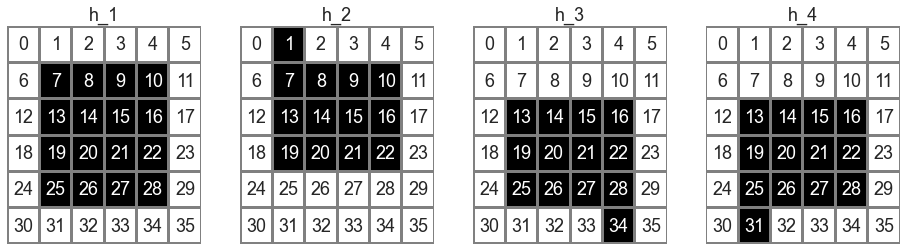

In [115]:
plot_problem_with_indices_startingfrom0(h)

In [ ]:
def plot_problem_with_probs_2(df):
    '''Plot probabilities heatmap given probabilities df'''
    problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle('$P_{teacher}(d|h)$', y=1.1)
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 
    #return problem